<a href="https://colab.research.google.com/github/ILoveCoder999/FederatedLearning/blob/master/centralizedModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# import module
import sys
sys.path.append('/content/drive/MyDrive')
from preprocessing import FederatedDataBuilder

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import os
import json
from datetime import datetime

# ============================================================
# 1. Model Definition (with Dropout)
# ============================================================
class DINOCIFAR100(nn.Module):
    def __init__(self, num_classes=100, dropout_rate=0.1):
        """
        DINO ViT-S/16 model for CIFAR-100 classification.
        
        Args:
            num_classes: Number of output classes (100 for CIFAR-100)
            dropout_rate: Dropout probability for regularization
        """
        super(DINOCIFAR100, self).__init__()
        print("Downloading/Loading DINO ViT-S/16...")
        self.backbone = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')
        self.embed_dim = 384

        # Add Dropout layer for regularization
        self.dropout = nn.Dropout(dropout_rate)
        self.head = nn.Linear(self.embed_dim, num_classes)

    def forward(self, x):
        """Forward pass through the network"""
        features = self.backbone(x)
        features = self.dropout(features)
        return self.head(features)


# ============================================================
# 2. Training & Evaluation Functions
# ============================================================
def train_one_epoch(model, loader, criterion, optimizer, device):
    """
    Train the model for one epoch.

    Args:
        model: Neural network model
        loader: Training data loader
        criterion: Loss function
        optimizer: Optimizer
        device: Device (cuda/cpu)

    Returns:
        avg_loss: Average loss for this epoch
        accuracy: Training accuracy (%)
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in tqdm(loader, desc="Training", leave=False):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    avg_loss = running_loss / len(loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy


def evaluate(model, loader, criterion, device):
    """
    Evaluate the model on validation/test set.

    Args:
        model: Neural network model
        loader: Validation/test data loader
        criterion: Loss function
        device: Device (cuda/cpu)

    Returns:
        avg_loss: Average loss
        accuracy: Accuracy (%)
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in tqdm(loader, desc="Evaluating", leave=False):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    avg_loss = running_loss / len(loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy


# ============================================================
# 3. Warmup + Cosine Decay Learning Rate Scheduler
# ============================================================
def get_lr_schedule(optimizer, warmup_epochs=5, total_epochs=50):
    """
    Create a learning rate scheduler with Warmup + Cosine Decay.

    - First warmup_epochs: Linear warmup from 0 to initial LR
    - Remaining epochs: Cosine annealing decay

    Args:
        optimizer: Optimizer
        warmup_epochs: Number of warmup epochs
        total_epochs: Total number of training epochs

    Returns:
        LambdaLR scheduler
    """
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            # Warmup phase: Linear growth from 0 to 1
            return epoch / warmup_epochs
        else:
            # Cosine Decay phase: Smooth decay
            progress = (epoch - warmup_epochs) / (total_epochs - warmup_epochs)
            return 0.5 * (1 + np.cos(np.pi * progress))

    return optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)


# ============================================================
# 4. Checkpointing Functions
# ============================================================
def save_checkpoint(epoch, model, optimizer, scheduler, best_acc, history, 
                   checkpoint_dir='checkpoints', filename='checkpoint.pth'):
    """
    Save training checkpoint.
    
    Args:
        epoch: Current epoch number
        model: Model state
        optimizer: Optimizer state
        scheduler: Scheduler state
        best_acc: Best validation accuracy so far
        history: Training history dictionary
        checkpoint_dir: Directory to save checkpoints
        filename: Checkpoint filename
    """
    os.makedirs(checkpoint_dir, exist_ok=True)
    checkpoint_path = os.path.join(checkpoint_dir, filename)
    
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'best_acc': best_acc,
        'history': history
    }, checkpoint_path)
    
    print(f"Checkpoint saved to {checkpoint_path}")


def load_checkpoint(checkpoint_path, model, optimizer=None, scheduler=None):
    """
    Load training checkpoint.
    
    Args:
        checkpoint_path: Path to checkpoint file
        model: Model to load state into
        optimizer: Optional optimizer to load state into
        scheduler: Optional scheduler to load state into
        
    Returns:
        start_epoch: Epoch to resume from
        best_acc: Best accuracy from checkpoint
        history: Training history
    """
    if not os.path.exists(checkpoint_path):
        print(f"No checkpoint found at {checkpoint_path}")
        return 0, 0.0, {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    print(f"Loading checkpoint from {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    if scheduler is not None:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    
    return checkpoint['epoch'] + 1, checkpoint['best_acc'], checkpoint['history']


# ============================================================
# 5. Experiment Logging
# ============================================================
class ExperimentLogger:
    """Simple logger for tracking experiments"""
    
    def __init__(self, log_dir='logs', experiment_name=None):
        """
        Initialize experiment logger.
        
        Args:
            log_dir: Directory to save logs
            experiment_name: Name of experiment (auto-generated if None)
        """
        os.makedirs(log_dir, exist_ok=True)
        
        if experiment_name is None:
            timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
            experiment_name = f'centralized_{timestamp}'
        
        self.log_file = os.path.join(log_dir, f'{experiment_name}.json')
        self.metrics = {
            'experiment_name': experiment_name,
            'start_time': datetime.now().isoformat(),
            'hyperparameters': {},
            'epochs': []
        }
    
    def log_hyperparameters(self, hparams):
        """Log hyperparameters"""
        self.metrics['hyperparameters'] = hparams
    
    def log_epoch(self, epoch, train_loss, train_acc, val_loss, val_acc, lr):
        """Log metrics for one epoch"""
        self.metrics['epochs'].append({
            'epoch': epoch,
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc,
            'learning_rate': lr
        })
    
    def log_final_results(self, test_loss, test_acc, total_epochs):
        """Log final test results"""
        self.metrics['end_time'] = datetime.now().isoformat()
        self.metrics['total_epochs'] = total_epochs
        self.metrics['test_loss'] = test_loss
        self.metrics['test_acc'] = test_acc
    
    def save(self):
        """Save logs to file"""
        with open(self.log_file, 'w') as f:
            json.dump(self.metrics, f, indent=2)
        print(f"Experiment log saved to {self.log_file}")


# ============================================================
# 6. Main Training Function (Enhanced)
# ============================================================
def run_centralized_baseline(config=None, seed=42, resume_from=None):
    """
    Main training function with all optimizations and best practices.
    
    Args:
        config: Dictionary with hyperparameters (if None, uses defaults)
        seed: Random seed for reproducibility
        resume_from: Path to checkpoint to resume from
        
    Returns:
        test_acc: Final test accuracy
        history: Training history
    """
    # Set random seeds for reproducibility
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    
    # ========== Hyperparameters ==========
    if config is None:
        config = {
            'batch_size': 128,
            'epochs': 50,
            'lr': 0.0001,
            'momentum': 0.9,
            'weight_decay': 5e-4,
            'dropout_rate': 0.1,
            'warmup_epochs': 5,
            'patience': 10
        }
    
    BATCH_SIZE = config['batch_size']
    EPOCHS = config['epochs']
    LR = config['lr']
    MOMENTUM = config['momentum']
    WEIGHT_DECAY = config['weight_decay']
    DROPOUT_RATE = config['dropout_rate']
    WARMUP_EPOCHS = config['warmup_epochs']
    PATIENCE = config['patience']

    # Device setup
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {DEVICE}")
    print(f"Random seed: {seed}")

    # ========== Initialize Logger ==========
    logger = ExperimentLogger(experiment_name=f'centralized_seed{seed}')
    logger.log_hyperparameters(config)

    # ========== Data Preparation ==========
    import torchvision.transforms as transforms

    # Training set: Apply data augmentation
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408),
                           (0.2675, 0.2565, 0.2761))
    ])

    # Validation/Test set: No augmentation
    transform_test = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408),
                           (0.2675, 0.2565, 0.2761))
    ])

    # Load datasets
    from preprocessing_simple import FederatedDataBuilder
    data_builder = FederatedDataBuilder(val_split_ratio=0.1)

    # Apply augmentation to training set
    data_builder.train_dataset.dataset.transform = transform_train

    train_loader = torch.utils.data.DataLoader(
        data_builder.train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
        num_workers=2, pin_memory=True
    )
    val_loader = torch.utils.data.DataLoader(
        data_builder.val_dataset, batch_size=BATCH_SIZE, shuffle=False, 
        num_workers=2, pin_memory=True
    )
    test_loader = torch.utils.data.DataLoader(
        data_builder.test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
        num_workers=2, pin_memory=True
    )

    print(f"\nDataset sizes:")
    print(f"  Training: {len(data_builder.train_dataset)}")
    print(f"  Validation: {len(data_builder.val_dataset)}")
    print(f"  Test: {len(data_builder.test_dataset)}")

    # ========== Model, Optimizer, Loss Function ==========
    model = DINOCIFAR100(num_classes=100, dropout_rate=DROPOUT_RATE).to(DEVICE)
    optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, 
                         weight_decay=WEIGHT_DECAY)
    criterion = nn.CrossEntropyLoss()
    scheduler = get_lr_schedule(optimizer, warmup_epochs=WARMUP_EPOCHS, 
                               total_epochs=EPOCHS)

    # ========== Resume from checkpoint if specified ==========
    start_epoch = 0
    best_val_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    if resume_from is not None:
        start_epoch, best_val_acc, history = load_checkpoint(
            resume_from, model, optimizer, scheduler
        )
        print(f"Resumed from epoch {start_epoch} with best acc {best_val_acc:.2f}%")

    # ========== Early Stopping Setup ==========
    no_improve_count = 0
    checkpoint_dir = 'checkpoints'
    best_model_path = os.path.join(checkpoint_dir, f'best_model_seed{seed}.pth')
    os.makedirs(checkpoint_dir, exist_ok=True)

    # ========== Training Loop ==========
    print(f"\n{'='*60}")
    print(f"Starting centralized training for {EPOCHS} epochs...")
    print(f"Hyperparameters: LR={LR}, Batch={BATCH_SIZE}, WD={WEIGHT_DECAY}")
    print(f"{'='*60}\n")

    for epoch in range(start_epoch, EPOCHS):
        # Train for one epoch
        t_loss, t_acc = train_one_epoch(model, train_loader, criterion, 
                                       optimizer, DEVICE)

        # Validate
        v_loss, v_acc = evaluate(model, val_loader, criterion, DEVICE)

        # Get current learning rate
        current_lr = optimizer.param_groups[0]['lr']

        # Update learning rate
        scheduler.step()

        # Record history
        history['train_loss'].append(t_loss)
        history['train_acc'].append(t_acc)
        history['val_loss'].append(v_loss)
        history['val_acc'].append(v_acc)

        # Log to experiment logger
        logger.log_epoch(epoch + 1, t_loss, t_acc, v_loss, v_acc, current_lr)

        # Early Stopping check
        if v_acc > best_val_acc:
            best_val_acc = v_acc
            torch.save(model.state_dict(), best_model_path)
            no_improve_count = 0
            print(f"✓ Epoch {epoch+1}/{EPOCHS} | LR: {current_lr:.6f} | "
                  f"Train Loss: {t_loss:.4f} Acc: {t_acc:.2f}% | "
                  f"Val Loss: {v_loss:.4f} Acc: {v_acc:.2f}% | "
                  f"NEW BEST! ⭐")
        else:
            no_improve_count += 1
            print(f"  Epoch {epoch+1}/{EPOCHS} | LR: {current_lr:.6f} | "
                  f"Train Loss: {t_loss:.4f} Acc: {t_acc:.2f}% | "
                  f"Val Loss: {v_loss:.4f} Acc: {v_acc:.2f}% | "
                  f"No improvement: {no_improve_count}/{PATIENCE}")

        # Save periodic checkpoint (every 10 epochs)
        if (epoch + 1) % 10 == 0:
            save_checkpoint(epoch, model, optimizer, scheduler, best_val_acc, 
                          history, checkpoint_dir, 
                          f'checkpoint_epoch{epoch+1}_seed{seed}.pth')

        # Stop training if no improvement for PATIENCE epochs
        if no_improve_count >= PATIENCE:
            print(f"\n⚠ Early stopping at epoch {epoch+1}")
            break

    # ========== Load Best Model for Final Test ==========
    print(f"\n{'='*60}")
    print("Training completed! Loading best model for testing...")
    print(f"{'='*60}\n")
    
    model.load_state_dict(torch.load(best_model_path))
    test_loss, test_acc = evaluate(model, test_loader, criterion, DEVICE)
    
    print(f"🎯 Final Results:")
    print(f"   Best Validation Accuracy: {best_val_acc:.2f}%")
    print(f"   Test Accuracy: {test_acc:.2f}%")
    print(f"   Test Loss: {test_loss:.4f}")

    # Log final results
    logger.log_final_results(test_loss, test_acc, epoch + 1)
    logger.save()

    # ========== Plot Training Curves ==========
    plot_results(history, save_path=f'figures/training_curves_seed{seed}.png')

    return test_acc, history


# ============================================================
# 7. Multiple Runs for Statistical Significance
# ============================================================
def run_multiple_experiments(num_runs=3, config=None):
    """
    Run multiple experiments with different random seeds.
    
    Args:
        num_runs: Number of independent runs
        config: Hyperparameter configuration
        
    Returns:
        results: List of test accuracies from each run
    """
    print(f"\n{'='*60}")
    print(f"Running {num_runs} independent experiments")
    print(f"{'='*60}\n")
    
    results = []
    
    for run in range(num_runs):
        seed = 42 + run
        print(f"\n{'#'*60}")
        print(f"# RUN {run+1}/{num_runs} (seed={seed})")
        print(f"{'#'*60}\n")
        
        test_acc, _ = run_centralized_baseline(config=config, seed=seed)
        results.append(test_acc)
    
    # Calculate statistics
    mean_acc = np.mean(results)
    std_acc = np.std(results)
    
    print(f"\n{'='*60}")
    print(f"FINAL RESULTS (across {num_runs} runs)")
    print(f"{'='*60}")
    print(f"Test Accuracy: {mean_acc:.2f}% ± {std_acc:.2f}%")
    print(f"Individual runs: {[f'{acc:.2f}%' for acc in results]}")
    print(f"{'='*60}\n")
    
    # Save aggregated results
    os.makedirs('logs', exist_ok=True)
    with open('logs/multiple_runs_summary.json', 'w') as f:
        json.dump({
            'num_runs': num_runs,
            'results': results,
            'mean': mean_acc,
            'std': std_acc,
            'config': config
        }, f, indent=2)
    
    return results


# ============================================================
# 8. Hyperparameter Search
# ============================================================
def hyperparameter_search():
    """
    Perform hyperparameter search over common parameters.
    This is a simple grid search - you can expand it as needed.
    
    Returns:
        best_config: Best hyperparameter configuration
        all_results: Results from all configurations
    """
    print(f"\n{'='*60}")
    print("HYPERPARAMETER SEARCH")
    print(f"{'='*60}\n")
    
    # Define search space (simplified for demonstration)
    search_space = {
        'lr': [0.0001, 0.0005, 0.001],
        'batch_size': [64, 128],
        'weight_decay': [1e-4, 5e-4]
    }
    
    # Base configuration
    base_config = {
        'epochs': 30,  # Reduced for search
        'momentum': 0.9,
        'dropout_rate': 0.1,
        'warmup_epochs': 5,
        'patience': 10
    }
    
    all_results = []
    best_acc = 0
    best_config = None
    
    # Grid search
    for lr in search_space['lr']:
        for batch_size in search_space['batch_size']:
            for weight_decay in search_space['weight_decay']:
                config = base_config.copy()
                config.update({
                    'lr': lr,
                    'batch_size': batch_size,
                    'weight_decay': weight_decay
                })
                
                print(f"\nTesting config: LR={lr}, BS={batch_size}, WD={weight_decay}")
                test_acc, _ = run_centralized_baseline(config=config, seed=42)
                
                all_results.append({
                    'config': config,
                    'test_acc': test_acc
                })
                
                if test_acc > best_acc:
                    best_acc = test_acc
                    best_config = config
                    print(f"✓ New best config! Acc={test_acc:.2f}%")
    
    # Save search results
    with open('logs/hyperparameter_search.json', 'w') as f:
        json.dump({
            'best_config': best_config,
            'best_acc': best_acc,
            'all_results': all_results
        }, f, indent=2)
    
    print(f"\n{'='*60}")
    print("HYPERPARAMETER SEARCH COMPLETE")
    print(f"{'='*60}")
    print(f"Best configuration:")
    for key, value in best_config.items():
        print(f"  {key}: {value}")
    print(f"Best test accuracy: {best_acc:.2f}%")
    print(f"{'='*60}\n")
    
    return best_config, all_results


# ============================================================
# 9. Plotting Function (Enhanced)
# ============================================================
def plot_results(history, save_path=None):
    """
    Plot training and validation loss/accuracy curves.

    Args:
        history: Dictionary containing training history
        save_path: Optional path to save figure
    """
    os.makedirs('figures', exist_ok=True)
    
    epochs = range(1, len(history['train_loss']) + 1)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Loss curve
    axes[0].plot(epochs, history['train_loss'], 'b-', label='Training Loss', linewidth=2)
    axes[0].plot(epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    axes[0].set_title('Loss over Epochs', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epochs', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)

    # Accuracy curve
    axes[1].plot(epochs, history['train_acc'], 'b-', label='Training Accuracy', linewidth=2)
    axes[1].plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy', linewidth=2)
    axes[1].set_title('Accuracy over Epochs', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epochs', fontsize=12)
    axes[1].set_ylabel('Accuracy (%)', fontsize=12)
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)
    
    # Add best validation accuracy marker
    best_val_idx = np.argmax(history['val_acc'])
    best_val_acc = history['val_acc'][best_val_idx]
    axes[1].axvline(x=best_val_idx+1, color='green', linestyle='--', 
                   alpha=0.5, label=f'Best: {best_val_acc:.2f}%')
    axes[1].legend(fontsize=11)

    plt.tight_layout()
    
    if save_path is None:
        save_path = 'figures/training_curves.png'
    
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"Training curves saved to {save_path}")
    plt.show()



Using device: cuda


100%|██████████| 169M/169M [00:13<00:00, 12.9MB/s]


Downloading/Loading DINO ViT-S/16...
Downloading: "https://github.com/facebookresearch/dino/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/dino/dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dino_deitsmall16_pretrain.pth


100%|██████████| 82.7M/82.7M [00:00<00:00, 163MB/s]


Starting centralized training for 50 epochs...


 Epoch 1/50 | New best model! Val Acc: 0.98%
Epoch 1/50 | LR: 0.000020 | Train Loss: 8.1562 Acc: 1.04% | Val Loss: 7.7938 Acc: 0.98%


 Epoch 2/50 | New best model! Val Acc: 28.32%
Epoch 2/50 | LR: 0.000040 | Train Loss: 4.2841 Acc: 8.82% | Val Loss: 2.8719 Acc: 28.32%


 Epoch 3/50 | New best model! Val Acc: 59.02%
Epoch 3/50 | LR: 0.000060 | Train Loss: 2.2648 Acc: 40.59% | Val Loss: 1.3943 Acc: 59.02%


 Epoch 4/50 | New best model! Val Acc: 73.28%
Epoch 4/50 | LR: 0.000080 | Train Loss: 1.1905 Acc: 65.40% | Val Loss: 0.8688 Acc: 73.28%


 Epoch 5/50 | New best model! Val Acc: 75.78%
Epoch 5/50 | LR: 0.000100 | Train Loss: 0.8163 Acc: 75.38% | Val Loss: 0.7785 Acc: 75.78%


 Epoch 6/50 | New best model! Val Acc: 78.90%
Epoch 6/50 | LR: 0.000100 | Train Loss: 0.6455 Acc: 80.14% | Val Loss: 0.6843 Acc: 78.90%


 Epoch 7/50 | New best model! Val Acc: 81.50%
Epoch 7/50 | LR: 0.000100 | Train Loss: 0.4878 Acc: 84.47% | Val Loss: 0.6038 Acc: 81.50%


 Epoch 8/50 | New best model! Val Acc: 81.90%
Epoch 8/50 | LR: 0.000099 | Train Loss: 0.3926 Acc: 87.40% | Val Loss: 0.6093 Acc: 81.90%


 Epoch 9/50 | New best model! Val Acc: 82.70%
Epoch 9/50 | LR: 0.000098 | Train Loss: 0.3123 Acc: 89.76% | Val Loss: 0.5965 Acc: 82.70%


 Epoch 10/50 | No improvement for 1 epochs
Epoch 10/50 | LR: 0.000097 | Train Loss: 0.2523 Acc: 91.54% | Val Loss: 0.6240 Acc: 81.96%


 Epoch 11/50 | New best model! Val Acc: 83.58%
Epoch 11/50 | LR: 0.000096 | Train Loss: 0.2028 Acc: 93.15% | Val Loss: 0.6255 Acc: 83.58%


 Epoch 12/50 | New best model! Val Acc: 83.96%
Epoch 12/50 | LR: 0.000094 | Train Loss: 0.1635 Acc: 94.47% | Val Loss: 0.5946 Acc: 83.96%


 Epoch 13/50 | New best model! Val Acc: 84.32%
Epoch 13/50 | LR: 0.000092 | Train Loss: 0.1291 Acc: 95.66% | Val Loss: 0.5916 Acc: 84.32%


 Epoch 14/50 | No improvement for 1 epochs
Epoch 14/50 | LR: 0.000090 | Train Loss: 0.0993 Acc: 96.59% | Val Loss: 0.6347 Acc: 84.02%


 Epoch 15/50 | New best model! Val Acc: 84.38%
Epoch 15/50 | LR: 0.000088 | Train Loss: 0.0733 Acc: 97.58% | Val Loss: 0.6461 Acc: 84.38%


 Epoch 16/50 | New best model! Val Acc: 84.82%
Epoch 16/50 | LR: 0.000086 | Train Loss: 0.0599 Acc: 98.11% | Val Loss: 0.6258 Acc: 84.82%


 Epoch 17/50 | New best model! Val Acc: 85.02%
Epoch 17/50 | LR: 0.000083 | Train Loss: 0.0476 Acc: 98.51% | Val Loss: 0.6474 Acc: 85.02%


 Epoch 18/50 | New best model! Val Acc: 85.52%
Epoch 18/50 | LR: 0.000081 | Train Loss: 0.0385 Acc: 98.85% | Val Loss: 0.6155 Acc: 85.52%


 Epoch 19/50 | New best model! Val Acc: 85.56%
Epoch 19/50 | LR: 0.000078 | Train Loss: 0.0323 Acc: 99.07% | Val Loss: 0.6394 Acc: 85.56%


 Epoch 20/50 | No improvement for 1 epochs
Epoch 20/50 | LR: 0.000075 | Train Loss: 0.0263 Acc: 99.31% | Val Loss: 0.6206 Acc: 85.48%


 Epoch 21/50 | New best model! Val Acc: 85.60%
Epoch 21/50 | LR: 0.000072 | Train Loss: 0.0205 Acc: 99.46% | Val Loss: 0.6384 Acc: 85.60%


 Epoch 22/50 | No improvement for 1 epochs
Epoch 22/50 | LR: 0.000069 | Train Loss: 0.0171 Acc: 99.61% | Val Loss: 0.6281 Acc: 85.56%


 Epoch 23/50 | New best model! Val Acc: 85.98%
Epoch 23/50 | LR: 0.000065 | Train Loss: 0.0154 Acc: 99.64% | Val Loss: 0.6254 Acc: 85.98%


 Epoch 24/50 | New best model! Val Acc: 86.14%
Epoch 24/50 | LR: 0.000062 | Train Loss: 0.0116 Acc: 99.76% | Val Loss: 0.6281 Acc: 86.14%


 Epoch 25/50 | New best model! Val Acc: 86.22%
Epoch 25/50 | LR: 0.000059 | Train Loss: 0.0111 Acc: 99.76% | Val Loss: 0.6093 Acc: 86.22%


 Epoch 26/50 | No improvement for 1 epochs
Epoch 26/50 | LR: 0.000055 | Train Loss: 0.0088 Acc: 99.81% | Val Loss: 0.6207 Acc: 86.14%


 Epoch 27/50 | New best model! Val Acc: 86.24%
Epoch 27/50 | LR: 0.000052 | Train Loss: 0.0074 Acc: 99.86% | Val Loss: 0.6270 Acc: 86.24%


 Epoch 28/50 | New best model! Val Acc: 86.36%
Epoch 28/50 | LR: 0.000048 | Train Loss: 0.0067 Acc: 99.89% | Val Loss: 0.6433 Acc: 86.36%


 Epoch 29/50 | New best model! Val Acc: 86.42%
Epoch 29/50 | LR: 0.000045 | Train Loss: 0.0068 Acc: 99.89% | Val Loss: 0.6220 Acc: 86.42%


 Epoch 30/50 | No improvement for 1 epochs
Epoch 30/50 | LR: 0.000041 | Train Loss: 0.0053 Acc: 99.93% | Val Loss: 0.6383 Acc: 86.42%


 Epoch 31/50 | No improvement for 2 epochs
Epoch 31/50 | LR: 0.000038 | Train Loss: 0.0050 Acc: 99.93% | Val Loss: 0.6482 Acc: 86.16%


 Epoch 32/50 | No improvement for 3 epochs
Epoch 32/50 | LR: 0.000035 | Train Loss: 0.0047 Acc: 99.92% | Val Loss: 0.6179 Acc: 85.98%


 Epoch 33/50 | New best model! Val Acc: 86.46%
Epoch 33/50 | LR: 0.000031 | Train Loss: 0.0046 Acc: 99.93% | Val Loss: 0.6314 Acc: 86.46%


 Epoch 34/50 | New best model! Val Acc: 86.54%
Epoch 34/50 | LR: 0.000028 | Train Loss: 0.0043 Acc: 99.94% | Val Loss: 0.6178 Acc: 86.54%


 Epoch 35/50 | No improvement for 1 epochs
Epoch 35/50 | LR: 0.000025 | Train Loss: 0.0033 Acc: 99.96% | Val Loss: 0.6325 Acc: 86.34%


 Epoch 36/50 | No improvement for 2 epochs
Epoch 36/50 | LR: 0.000022 | Train Loss: 0.0036 Acc: 99.96% | Val Loss: 0.6172 Acc: 86.44%


 Epoch 37/50 | New best model! Val Acc: 86.84%
Epoch 37/50 | LR: 0.000019 | Train Loss: 0.0037 Acc: 99.94% | Val Loss: 0.6045 Acc: 86.84%


 Epoch 38/50 | No improvement for 1 epochs
Epoch 38/50 | LR: 0.000017 | Train Loss: 0.0035 Acc: 99.95% | Val Loss: 0.6099 Acc: 86.82%


 Epoch 39/50 | No improvement for 2 epochs
Epoch 39/50 | LR: 0.000014 | Train Loss: 0.0032 Acc: 99.97% | Val Loss: 0.6338 Acc: 86.42%


 Epoch 40/50 | New best model! Val Acc: 87.12%
Epoch 40/50 | LR: 0.000012 | Train Loss: 0.0033 Acc: 99.96% | Val Loss: 0.6051 Acc: 87.12%


 Epoch 41/50 | No improvement for 1 epochs
Epoch 41/50 | LR: 0.000010 | Train Loss: 0.0032 Acc: 99.96% | Val Loss: 0.6243 Acc: 86.56%


 Epoch 42/50 | No improvement for 2 epochs
Epoch 42/50 | LR: 0.000008 | Train Loss: 0.0030 Acc: 99.96% | Val Loss: 0.6051 Acc: 86.66%


 Epoch 43/50 | No improvement for 3 epochs
Epoch 43/50 | LR: 0.000006 | Train Loss: 0.0030 Acc: 99.96% | Val Loss: 0.6139 Acc: 86.66%


 Epoch 44/50 | No improvement for 4 epochs
Epoch 44/50 | LR: 0.000004 | Train Loss: 0.0027 Acc: 99.97% | Val Loss: 0.6162 Acc: 86.16%


 Epoch 45/50 | No improvement for 5 epochs
Epoch 45/50 | LR: 0.000003 | Train Loss: 0.0026 Acc: 99.98% | Val Loss: 0.6084 Acc: 86.78%


 Epoch 46/50 | No improvement for 6 epochs
Epoch 46/50 | LR: 0.000002 | Train Loss: 0.0027 Acc: 99.96% | Val Loss: 0.6073 Acc: 86.70%


 Epoch 47/50 | No improvement for 7 epochs
Epoch 47/50 | LR: 0.000001 | Train Loss: 0.0025 Acc: 99.98% | Val Loss: 0.6158 Acc: 86.52%


 Epoch 48/50 | No improvement for 8 epochs
Epoch 48/50 | LR: 0.000000 | Train Loss: 0.0028 Acc: 99.97% | Val Loss: 0.6151 Acc: 86.92%


 Epoch 49/50 | No improvement for 9 epochs
Epoch 49/50 | LR: 0.000000 | Train Loss: 0.0027 Acc: 99.97% | Val Loss: 0.6126 Acc: 86.76%


 Epoch 50/50 | No improvement for 10 epochs
 Early stopping at epoch 50



🎯 Final Test Accuracy: 87.50%


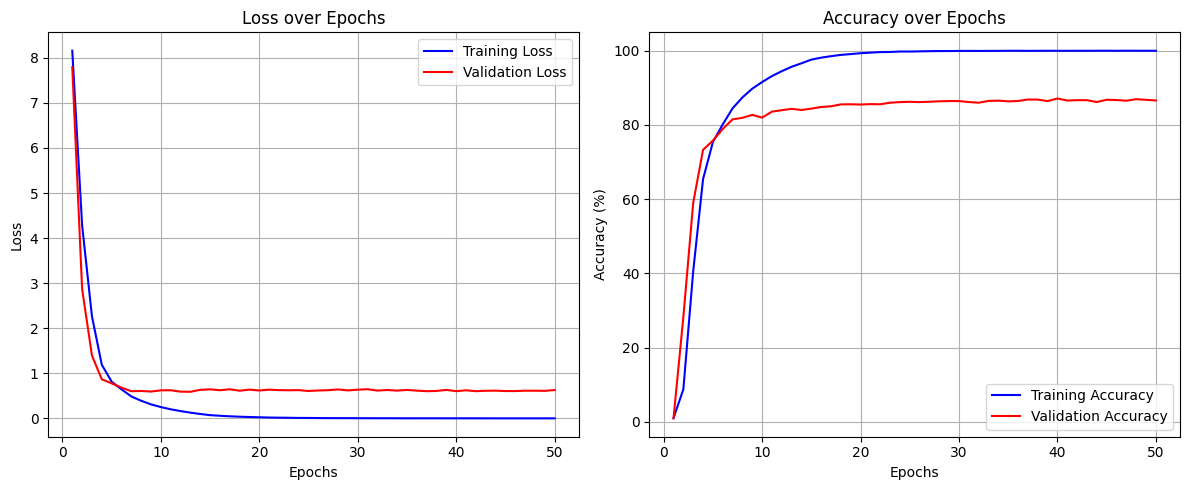

In [ ]:
# ============================================================
# 10. Main Entry Point
# ============================================================
if __name__ == "__main__":
    # Create necessary directories
    os.makedirs('checkpoints', exist_ok=True)
    os.makedirs('logs', exist_ok=True)
    os.makedirs('figures', exist_ok=True)
    
    # Option 1: Single run with default config
    print("Option 1: Single run with default configuration")
    test_acc, history = run_centralized_baseline()
    
    # Option 2: Multiple runs for statistical significance
    # print("Option 2: Multiple runs for statistical significance")
    # results = run_multiple_experiments(num_runs=3)
    
    # Option 3: Hyperparameter search (commented out - takes time)
    # print("Option 3: Hyperparameter search")
    # best_config, all_results = hyperparameter_search()
    # print(f"Best config: {best_config}")